In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History

In [3]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()


C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [7]:
visible = Input(shape=(X_train.shape[1],))
hidden1 = Dense(100, activation='sigmoid')(visible)
hidden2 = Dense(50, activation='sigmoid')(hidden1)
hidden3 = Dense(10, activation='sigmoid')(hidden2)
output = Dense(1, activation='sigmoid')(hidden3)
model = Model(inputs=visible, outputs=output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               4200      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [8]:
history_sgd = History()
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

Epoch 1/100
943/943 [==============================] - 1s 1ms/step - loss: 0.5234 - accuracy: 0.7541 - val_loss: 0.4022 - val_accuracy: 0.8028
Epoch 2/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3554 - accuracy: 0.8336 - val_loss: 0.3408 - val_accuracy: 0.8422
Epoch 3/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3372 - accuracy: 0.8419 - val_loss: 0.3370 - val_accuracy: 0.8402
Epoch 4/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3323 - accuracy: 0.8448 - val_loss: 0.3311 - val_accuracy: 0.8445
Epoch 5/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3299 - accuracy: 0.8461 - val_loss: 0.3350 - val_accuracy: 0.8398
Epoch 6/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3281 - accuracy: 0.8472 - val_loss: 0.3276 - val_accuracy: 0.8458
Epoch 7/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3265 - accuracy: 0.8471 - val_loss: 0.3283 - val_accuracy: 0.8459

Epoch 58/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3037 - accuracy: 0.8576 - val_loss: 0.3213 - val_accuracy: 0.8508
Epoch 59/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3036 - accuracy: 0.8584 - val_loss: 0.3205 - val_accuracy: 0.8501
Epoch 60/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3029 - accuracy: 0.8581 - val_loss: 0.3239 - val_accuracy: 0.8461
Epoch 61/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3032 - accuracy: 0.8583 - val_loss: 0.3212 - val_accuracy: 0.8480
Epoch 62/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3026 - accuracy: 0.8581 - val_loss: 0.3249 - val_accuracy: 0.8501
Epoch 63/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3029 - accuracy: 0.8588 - val_loss: 0.3213 - val_accuracy: 0.8469
Epoch 64/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3020 - accuracy: 0.8593 - val_loss: 0.3238 - val_accuracy:

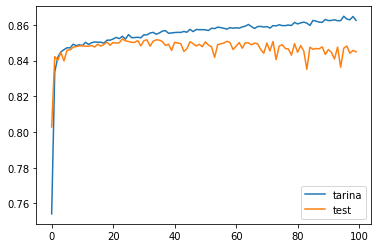

In [9]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Zad 

Zbuduj i przetestuj sieć przestawioną na rysunku:

<img src="https://adeshpande3.github.io/assets/LeNet.png" width="700">
Źródło: https://adeshpande3.github.io/assets/LeNet.png"